```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import copy
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

from time import time
from IPython.display import clear_output

from fnn import PoseFFNN
from helper import plot, get_pose_names
from dataloader.dataloader import load_data, PoseLoader

In [ ]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [3]:
poses = get_pose_names()

In [4]:
myPath = os.getcwd()

myYogaPath = os.path.join(myPath, 'yoga')
myRawPath = os.path.join(myPath, 'data', 'raw')
myFixedPath = os.path.join(myPath, 'data', 'fixed')

myYogaFolders = os.listdir(myYogaPath)
myRawFiles = os.listdir(myRawPath)
myFixedFiles = os.listdir(myFixedPath)

In [39]:
rawTrain, rawVal, rawTest = load_data(myYogaFolders, 'raw')
fixedTrain, fixedVal, fixedTest = load_data(myYogaFolders, 'fixed')
# filteredTrain, filteredVal, filteredTest = load_data(myYogaFolders, 'filtered', 90)

train_data = PoseLoader(rawTrain, 'train', oneHot=True)
val_data = PoseLoader(rawVal, 'val', oneHot=True)
test_data = PoseLoader(rawTest, 'test', oneHot=True)

In [40]:
def get_accuracy(model, data, device):

    totalVals = len(data)
    totalCorrect = 0
    for i in range(totalVals):
        output = model(val_data[i]['input'].to(device))
        prediciton = output.argmax(dim=0, keepdim=True)
        correct = val_data[i]['label'].argmax(dim=0, keepdim=True).to(device)
        if prediciton == correct:
            totalCorrect += 1

    return totalCorrect / totalVals

def train(model, train_loader, val_data, optimizer, criterion, epochs, batch_size):

    device = None
    # Check for CUDA availability
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    # Set the device for the model
    model.to(device)

    # Set the model to train mode
    model.train()
    
    totalVals = len(train_loader) * batch_size
    totalCorrect = 0
    train_accuracy = []
    val_accuracy = []

    # Loop through the epochs
    for epoch in range(epochs):
        
        thisTotalCorrect = 0

        # Loop through the training data
        for batch_idx, batch_data in tqdm(enumerate(train_loader)):

            # Get the inputs and labels for this batch
            # Move input and target tensors to the device (GPU or CPU)
            inputs = batch_data['input'].to(device)
            targets = batch_data['label'].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Calculate the accuracy
            pred_values = outputs.argmax(dim=1, keepdim=True)
            true_values = targets.argmax(dim=1, keepdim=True)

            thisTotalCorrect += sum([pred_values[i] == true_values[i] for i in range(len(true_values))])

        clear_output(wait=True)
        # Divide the total loss and accuracy by the number of training examples to get the average
        totalCorrect += thisTotalCorrect
        thisAcc = thisTotalCorrect / totalVals

        train_accuracy.append(thisAcc)
        val_accuracy.append(get_accuracy(model, val_data, device)) 

        # plot the accuracies
        plt.clf()
        plt.plot(range(epoch+1), [acc.cpu().numpy() for acc in train_accuracy], color='b')
        plt.plot(range(epoch+1), val_accuracy, color='g')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')
        plt.show()
        print(f'Epoch {epoch + 1}/{epochs} | Training accuracy: {thisAcc.item():.4f}')
        print(f'Epoch {epoch + 1}/{epochs} | Validation accuracy: {val_accuracy[-1]:.4f}')

    return train_accuracy, val_accuracy

In [45]:
def go_nuts():

    device = None

    # Check for CUDA availability
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    input_dim = len(train_data[0]['input'])
    output_dim = len(poses)

    # Define your model
    model = PoseFFNN(input_dim, output_dim)

    # Add L2 regularization to the optimizer
    L2_reg = 0.001

    # Set up your optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=L2_reg)

    # Set up your loss function
    criterion = nn.CrossEntropyLoss()

    batch_size = 64
    epocs = 50

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_accuracy, val_accuracy = train(model, train_loader, val_data, optimizer, criterion, epocs, batch_size)
    
    return model

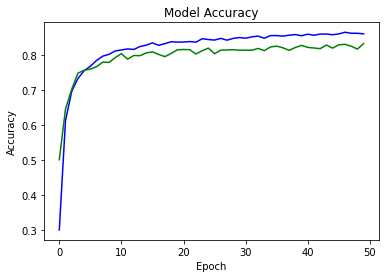

Epoch 50/50 | Training accuracy: 0.8593
Epoch 50/50 | Validation accuracy: 0.8315


In [46]:
model = go_nuts()

In [47]:
device = None

# Check for CUDA availability
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print('val accuracy :', get_accuracy(model, val_data, device))
print('test accuracy :', get_accuracy(model, test_data, device))

val accuracy : 0.8314875785692907
test accuracy : 0.8321762752792031
